In [68]:
from matplotlib import pyplot as plt
from elevator import ElevatorSimulation
from frc3223_azurite import motors
from frc3223_azurite.conversions import *
from frc3223_azurite import inertials
import pathfinder as pf
import frccontrol as frccnt
import control
import numpy

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, sim.xs)
    if ylim is None:
        ylim = (-sim.max_height_m * 0.1, sim.max_height_m * 1.1)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (m)')
    plt.show()
    
def plot_velocity(sim):
    m2ft = numpy.vectorize(lambda mps: mps)
    plt.plot(sim.ts, m2ft(sim.vs))
    #plt.ylim(-10, 10)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (m/s)')
    plt.show()
    
def plot_jerk(sim):
    delta_as = sim.a_s[1:] - sim.a_s[0:-1]
    delta_ts = sim.ts[1:] - sim.ts[0:-1]
    jerk = delta_as / delta_ts
    plt.plot(sim.ts[2:], jerk[1:])
    plt.xlabel('time (s)')
    plt.ylabel('approx jerk (m/s^3)')
    plt.show()
    
def plot_acc(sim):
    plt.plot(sim.ts,sim.a_s)
    plt.xlabel('time (s)')
    plt.ylabel('acceleration (m/s^2)')
    plt.show()
    

def plot_voltage_percent(sim):
    plt.plot(sim.ts, 100 * sim.voltageps)
    plt.ylim(-120, 120)
    plt.xlabel('time (s)')
    plt.ylabel('voltage (% available)')
    plt.show()

def plot_current(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.currents)
    plt.ylim(-40, 40)
    plt.xlabel('time (s)')
    plt.ylabel('current (A)')
    plt.show()
    
def plot_voltage(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.voltages)
    plt.ylim(0, 13)
    plt.xlabel('time (s)')
    plt.ylabel('voltage (V)')
    plt.show()
    
# theiverized from 971's 2013 code release
def exact_c2d(A, B, dt):
  """
  Converts from continuous time state space representation to discrete time.
  Evaluates e^(A dt) for the discrete time version of A, and
  integral(e^(A t) * B, 0, dt).
  Returns (A, B).  C and D are unchanged.
  """
  e, P = numpy.linalg.eig(A)
  diag = numpy.matrix(numpy.eye(A.shape[0]))
  diage = numpy.matrix(numpy.eye(A.shape[0]))
  for eig, count in zip(e, range(0, A.shape[0])):
    diag[count, count] = numpy.exp(eig * dt)
    if abs(eig) < 1.0e-16:
      diage[count, count] = dt
    else:
      diage[count, count] = (numpy.exp(eig * dt) - 1.0) / eig

  return (P * diag * numpy.linalg.inv(P), P * diage * numpy.linalg.inv(P) * B)

# for monkey patching StateSpace.sample when you suspect cont2discrete is lying and exact 
# discretization will work better
# (it probably won't)
def monkey_patch_sample(ss):
    def exact_sample(dt):
        self = ss
        if not self.isctime():
            raise ValueError("System must be continuous time system")

        Ad, Bd = exact_c2d(self.A, self.B, dt)
        return control.StateSpace(Ad, Bd, self.C, self.D, dt)
    ss.sample = exact_sample

ks: 3.016199
kv: 3.042643
ka: 0.000598
A continuous:  [[ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -5.08733909e+03]]
B continuous:  [[   0.        ]
 [1672.01322057]]
 A:  [[1.00000000e+00 1.96566414e-04]
 [0.00000000e+00 6.48536053e-45]]
eig(A):  (array([1.00000000e+00, 6.48536053e-45]), matrix([[ 1.00000000e+00, -1.96566410e-04],
        [ 0.00000000e+00,  9.99999981e-01]]))
 B:  [[0.00650863]
 [0.32866164]]
 Aiv:  [[ 1.00000000e+00 -3.03092500e+40]
 [ 0.00000000e+00  1.54193432e+44]]
raise
muh gravity force:  151.293744
muh masses:  4.536 5.4432


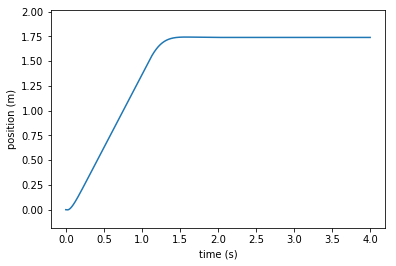

1.7384206779914564


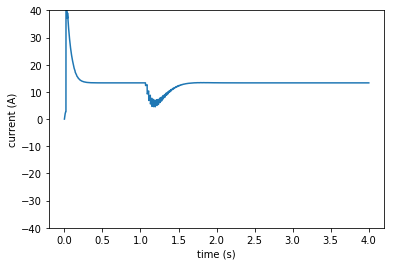

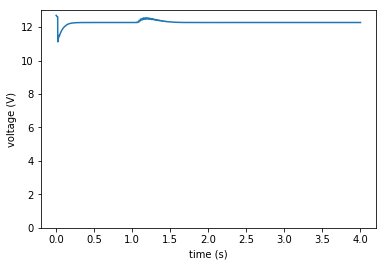

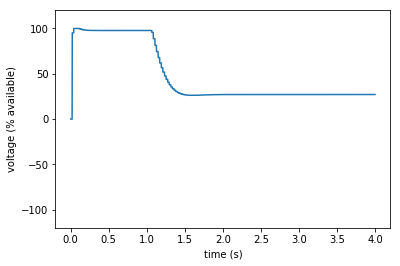

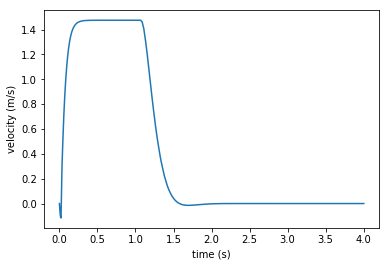

1.27
naive


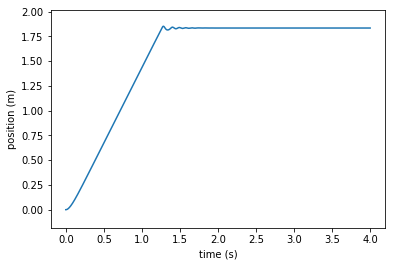

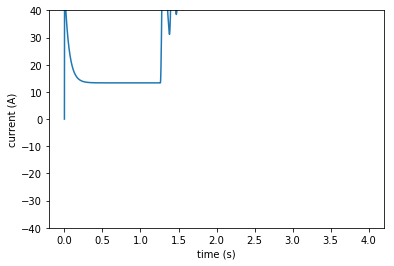

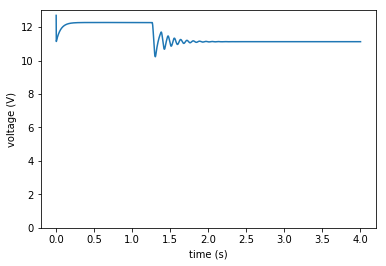

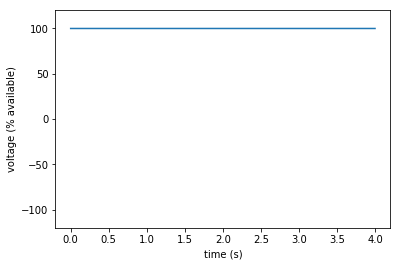

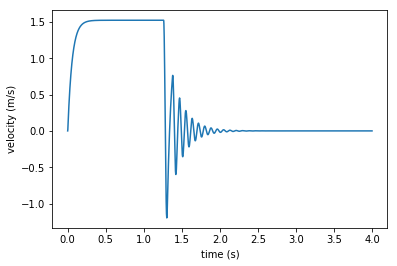

0.254
1.8333734911479787


In [70]:
class Elevator(frccnt.System):
    def __init__(self, dt):
        state_labels = [
            ("position", "m"),
            ("velocity", "m/s"),
        ]
        u_labels = [("voltage", "V")]
        self.set_plot_labels(state_labels, u_labels)
        
        
        
        self.DT = dt
        self.radius = r = inch_to_meter(0.5625)
        self.j = j = inertials.solid_cylinder(0.12, r) # moment of inertia of sprocket
        self.m1=m1 = lbs_to_kg(10)
        self.m2 = m2 = lbs_to_kg(12)
        self.spring_force = lbs_to_N(0.0)
        self.motor_system = ms = motors.MotorSystem(motor=motors.bag, motor_count=2, gearing_ratio=10)
        
        
        
        Ka = j * ms.motor.resistance() / (2 * r * ms.motor.ktorque() * ms.motor_count * ms.gearing_ratio)
        Kv = ms.motor.kspeed() * ms.gearing_ratio / 2 / r
        self.Ks = Ks = ms.motor.resistance() * r * (g * (m1 + 2 * m2) - self.spring_force) / (ms.motor.ktorque() * ms.motor_count * ms.gearing_ratio)
        print("ks: %f" % Ks)
        print("kv: %f" % Kv)
        print("ka: %f" % Ka)
        A = numpy.array([
            [0, 1],
            [0, -Kv/Ka],
        ])
        print("A continuous: ", A)
        B = numpy.array([
            [0],
            [1/Ka],
        ])
        print("B continuous: ", B)
        C = numpy.array([
            [1, 0],
        ])
        D = numpy.zeros(shape=(1,1))
        
        self.model = control.ss(A, B, C, D)
        
        
        #monkey_patch_sample(self.model)
        self.model.sample(0.02)
        
        self.u_min = u_min = numpy.matrix([[-12.0]])
        self.u_max = u_max = numpy.matrix([[12.0]])
        
        
        
        try:
            frccnt.System.__init__(self, self.model, u_min, u_max, dt)
            q = [0.05, 0.5]
            r = [12.0]
            self.design_dlqr_controller(q, r)
            self.design_two_state_feedforward(q, r)

            q_pos = 0.15
            q_vel = 1.0
            r_pos = 0.0001
            self.design_kalman_filter([q_pos, q_vel], [r_pos])
        finally:
            pass
    
    def make_sim(self, init, periodic, starting_pos):
        return ElevatorSimulation(
            starting_position_m=starting_pos,
            max_height_m=inch_to_meter(72),
            sprocket_radius_m=self.radius,
            robot_mass_kg=lbs_to_kg(154),
            stage1_mass_kg=(self.m1),
            stage2_mass_kg=(self.m2),
            stage3_mass_kg=(0.0),
            stage1_counterweighting_n=self.spring_force,
            stage2_counterweighting_n=lbs_to_N(0),
            friction_force_N=0,
            pulls_down = True,
            init=init,
            battery_voltage=12.7,
            periodic=periodic,
            periodic_period=self.DT,
            pid_sample_rate_s=0.001,
            gearbox_efficiency=1,
            motor_system=self.motor_system,
            dt_s=0.001,
        )
    def run_sim(self, starting_pos, setpoint):
        def init(state):
            state.u = numpy.zeros(shape=(self.sysd.B.shape[1], 1))
            state.u_offset = numpy.zeros(shape=state.u.shape)
            #self.u_max[0, 0] -= self.Ks
            #self.u_min[0, 0] -= self.Ks
            state.u_offset[0,0] = -self.Ks
            state.y = numpy.zeros((self.sysd.C.shape[0], 1))
            state.r = numpy.zeros((self.sysd.A.shape[0], 1))
            state.x_hat = numpy.zeros((self.sysd.A.shape[0], 1))
            state.Ainv = numpy.linalg.inv(self.sysd.A)
            #state.Ainv = numpy.eye(self.sysd.A.shape[0])
            
        def update_input(state, next_r):
            state.u = self.K @ (state.r - state.x_hat)
            uff = self.Kff @ (next_r  - self.sysd.A @ state.r)
            state.r = next_r
            state.u = numpy.clip(state.u + uff - state.u_offset, self.u_min, self.u_max)
            
        def periodic(state):
            setpoint_pos = setpoint
            state.x_hat += state.Ainv @ self.L @ (state.y - self.sysd.C @ state.x_hat - self.sysd.D @ state.u)
            update_input(state, numpy.array([[setpoint_pos, 0]]).T)
            vp = (state.u[0,0] + self.Ks * 0) / state.voltage
            state.motor.set(vp)
            state.y[0,0] = state.x
            state.x_hat = self.sysd.A @ state.x_hat + self.sysd.B @ state.u
            #print("estimated: %.2f m, %.2f m/s" % (state.x_hat[0, 0], state.x_hat[1, 0]))
            #print("actual: %.2f m, %.2f m/s" % (state.x, state.velocity_mps))
            #print("input: %.1f V (%.1f%%)" %(state.u[0,0], vp*100))
            
        sim = self.make_sim(init, periodic,starting_pos)
        sim.run_lift_sim(timeout=4)
        return sim
    
    def run_naive_sim(self, starting_pos, setpoint):
        def init(state):
            state.motor.set(self.Ks)
            
        def periodic(state):
            if state.x > setpoint:
                state.motor.set(0.23)
            else:
                state.motor.set(1)
                
            
        sim = self.make_sim(init, periodic,starting_pos)
        sim.run_lift_sim(timeout=4)
        return sim
    
    def run_motion_profile_sim(self, starting_pos, setpoint):
        points = [
            pf.Waypoint(starting_pos, 0, 0), 
            pf.Waypoint(setpoint, 0, 0)
        ]
        info, trajectory = pf.generate(points, pf.FIT_HERMITE_CUBIC, pf.SAMPLES_HIGH,
                                   dt=self.DT,
                                   max_velocity=3,
                                   max_acceleration=35.0,
                                   max_jerk = 60.0)
        def init(state):
            state.i = 0
            sim.setpoint_times = []
            sim.setpoints = []
            sim.setpoint_velocities = []
            state.u = numpy.zeros(shape=(self.sysd.B.shape[1], 1))
            state.u_offset = numpy.zeros(shape=state.u.shape)
            state.u_offset[0,0] = -self.Ks
            state.y = numpy.zeros((self.sysd.C.shape[0], 1))
            state.r = numpy.zeros((self.sysd.A.shape[0], 1))
            state.x_hat = numpy.zeros((self.sysd.A.shape[0], 1))
            state.Ainv = numpy.linalg.inv(self.sysd.A)
            
        def update_input(state, next_r):
            state.u = self.K @ (state.r - state.x_hat)
            uff = self.Kff @ (next_r  - self.sysd.A @ state.r)
            state.r = next_r
            state.u = numpy.clip(state.u + uff - state.u_offset, self.u_min, self.u_max)
            
        def periodic(state):
            setpoint_pos = trajectory[state.i].x
            setpoint_velocity = trajectory[state.i].velocity
            if state.i < len(trajectory)-1:
                state.i += 1
            sim.setpoints.append(setpoint_pos)
            sim.setpoint_velocities.append(setpoint_velocity)
            sim.setpoint_times.append(state.time_from_start_s)
            state.x_hat += state.Ainv @ self.L @ (state.y - self.sysd.C @ state.x_hat - self.sysd.D @ state.u)
            update_input(state, numpy.array([[setpoint_pos, 0]]).T)
            state.motor.set((state.u[0,0]+self.Ks) / state.voltage)
            state.y[0,0] = state.x
            state.x_hat = self.sysd.A @ state.x_hat + self.sysd.B @ state.u
            
        sim = self.make_sim(init, periodic,starting_pos)
        sim.run_lift_sim(timeout=4)
        sim.trajectory = trajectory
        return sim
        
        
e = Elevator(0.02)
print(" A: ",e.sysd.A)
print("eig(A): ", numpy.linalg.eig(e.sysd.A))
print(" B: ",e.sysd.B)
print(" Aiv: ", numpy.linalg.inv(e.sysd.A))


print("raise")
print("muh gravity force: ", (e.m1 + 2* e.m2) * g)
print("muh masses: ", e.m1, e.m2)
sim = e.run_sim(0, 1.75)
plot_position(sim)
print(sim.xs[-1])
plot_current(sim)
plot_voltage(sim)
plot_voltage_percent(sim)
plot_velocity(sim)
print(inch_to_meter(50))



print("naive")
sim = e.run_naive_sim(inch_to_meter(0), inch_to_meter(600))
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_voltage_percent(sim)
plot_velocity(sim)
print(inch_to_meter(10))
print(sim.xs[-1])



comment="""
print("raise")
sim = e.run_plant_augment_sim(0, 1)
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_voltage_percent(sim)
plot_velocity(sim)
print(inch_to_meter(50))
print(sim.xs[-1])
"""





profiled raise


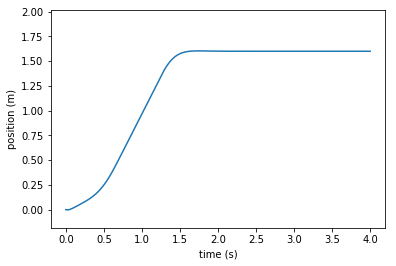

1.5989244530525815


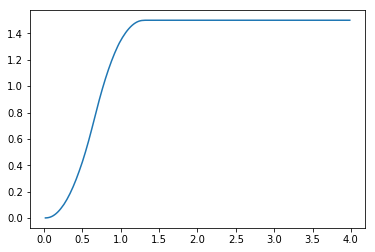

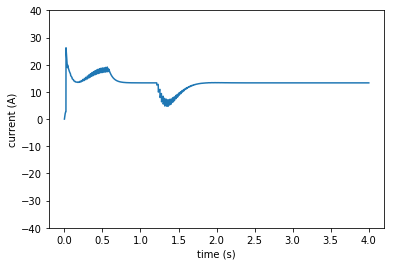

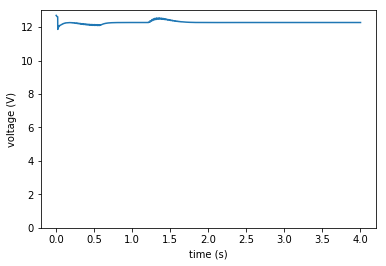

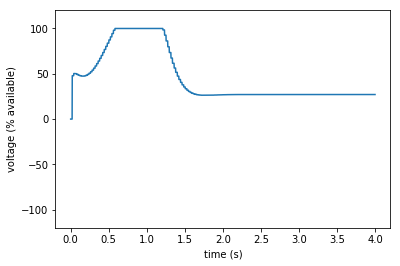

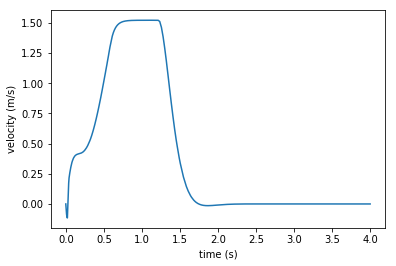

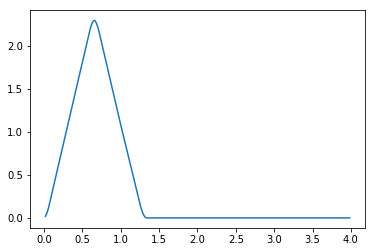

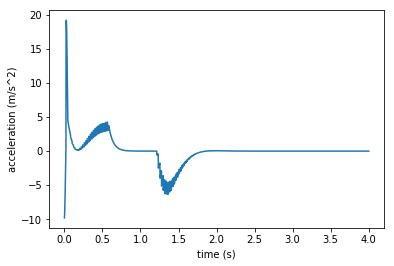

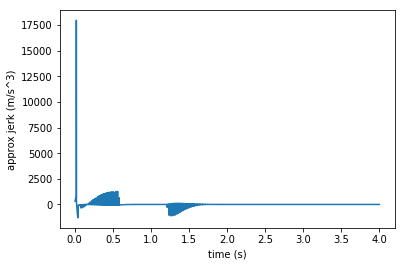

lower


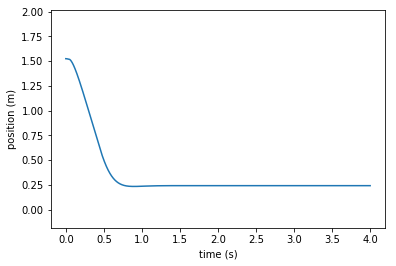

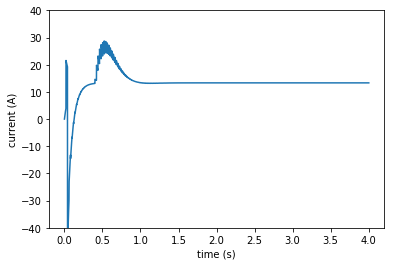

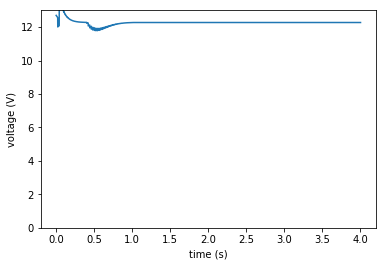

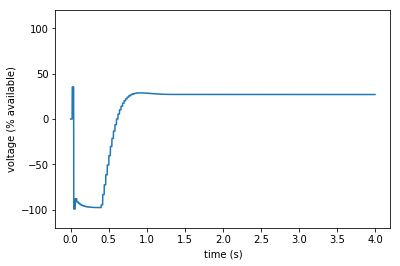

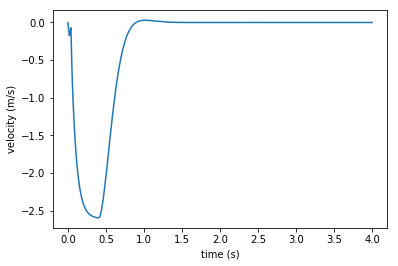

0.254
0.24242067794210453
ram top
ks: 3.016199
kv: 3.042643
ka: 0.000598
A continuous:  [[ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -5.08733909e+03]]
B continuous:  [[   0.        ]
 [1672.01322057]]


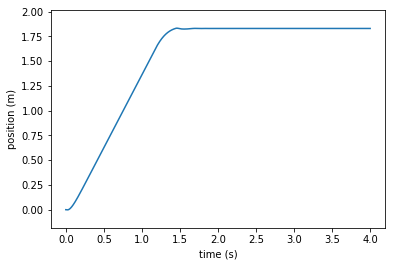

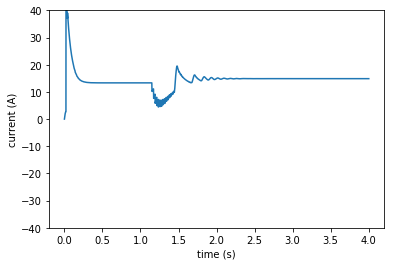

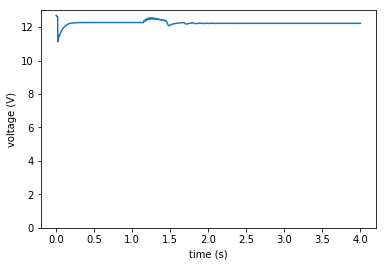

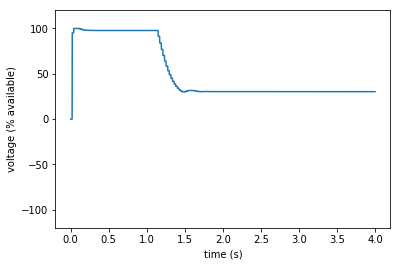

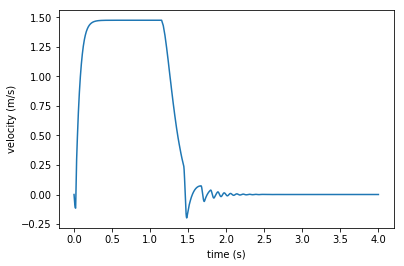

1.8288
1.8289977469161234


In [71]:
print("profiled raise")
sim = e.run_motion_profile_sim(0, 1.5)
plot_position(sim)
print(sim.xs[-1])
plt.plot(sim.setpoint_times, sim.setpoints)
plt.show()
plot_current(sim)
plot_voltage(sim)
plot_voltage_percent(sim)
plot_velocity(sim)
plt.plot(sim.setpoint_times, sim.setpoint_velocities)
plt.show()
plot_acc(sim)
plot_jerk(sim)




print("lower")
sim = e.run_sim(inch_to_meter(60), inch_to_meter(10))
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_voltage_percent(sim)
plot_velocity(sim)
print(inch_to_meter(10))
print(sim.xs[-1])





print("ram top")
e = Elevator(0.02)
sim = e.run_sim(0, inch_to_meter(73))
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_voltage_percent(sim)
plot_velocity(sim)
print(inch_to_meter(72))
print(sim.xs[-1])

In [4]:
print(" A: ",e.sysd.A)

print(" Aiv: ", numpy.linalg.inv(e.sysd.A))
print(" B: ",e.sysd.B)
print(" C: ",e.sysd.C)
print(" D: ",e.sysd.D)
print(" K: ",e.K)
print(" Kff: ",e.Kff)
print(" L: ",e.L)

def badkurk(e):
    r_next = numpy.array([[1.],[0]])
    r_prev = numpy.array([[0.],[0]])
    x_prev = numpy.array([[0.1],[0.1]])
    u_offset = numpy.array([[0.]])
    u = numpy.array([[0.]])
    y_obs = numpy.array([[0.]])
    y_est = numpy.array([[0.]])
    x_curr = None
    Ainv = numpy.linalg.inv(e.sysd.A)

    def update_input():
        nonlocal u, r_prev, r_next, e, u_offset, x_prev
        u = e.K @ (r_prev - x_prev)
        uff = e.Kff @ (r_next  - e.sysd.A @ r_prev)
        r_prev = r_next
        u = numpy.clip(u + uff - u_offset, e.u_min, e.u_max)

    def predict():
        nonlocal x_prev, u, e
        x_prev = e.sysd.A @ x_prev + e.sysd.B @ u

    def update():
        nonlocal x_prev, y_est, e, y_obs
        y_est = e.sysd.C @ x_prev
        x_prev += Ainv @ e.L @ (y_obs - y_est)

    print("x: ", x_prev)
    print("u: ", u)

    for i in range(200):
        update()
        update_input()
        y_obs = y_est
        predict()

        print("%s, %s, %s, %s" %(x_prev[0,0], x_prev[1,0], u[0,0], "shaddap"))

#badkurk(e)



print(inch_to_meter(50))
print(sim.xs[-1])

 A:  [[1.00000000e+00 7.86265655e-04]
 [0.00000000e+00 8.97394764e-12]]
 Aiv:  [[ 1.00000000e+00 -8.76164746e+07]
 [ 0.00000000e+00  1.11433679e+11]]
 B:  [[0.01262963]
 [0.65732328]]
 C:  [[1 0]]
 D:  [[0.]]
 K:  [[1.02412218e+01 8.05232098e-03]]
 Kff:  [[1.50052309 1.38838008]]
 L:  [[9.99999556e-01]
 [2.83840937e-24]]
1.27
1.828556723989332


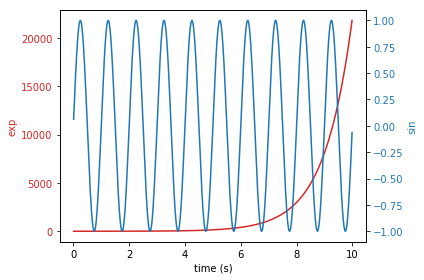

In [6]:
# Create some mock data
np = numpy
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
